In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import fnmatch

import pandas as pd
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt
from skimage import feature
from skimage import measure
from skimage.filters import threshold_otsu

from sklearn import preprocessing

from scipy import ndimage

from skimage.feature import peak_local_max
from skimage.morphology import extrema
from skimage.measure import label
from skimage import color

import json

## Load Data

In [3]:
dest_path = "data\\heparin\\agg\\"
id_file_name = 'ids.csv'
json_file_name = 'img_data.json'

In [4]:
imgs = []

'''for file in os.listdir(dest_path):
    if fnmatch.fnmatch(file, '*.npy'):
        imgs.append(np.load(dest_path+file))

'''       

df = pd.read_csv(dest_path+id_file_name)

for path in df['name']:
    imgs.append(np.load(dest_path+path+".npy"))
    
imgs = np.array(imgs) 

In [5]:
print(imgs.shape)

(276, 685, 377)


## Peak Point

In [6]:
peak = imgs.max(1).max(1)
df['peak_val'] = peak
print(df.shape)

(276, 6)


## Drop other objects

In [7]:
#binarizer = preprocessing.Binarizer().fit(imgs[0])
#edges = binarizer.transform(imgs[0])

#edges = feature.canny(imgs[0], sigma=3)

# Otsu's thresholding after Gaussian filtering

img_masks = []
label_imgs = []
num_peaks = []
save_plt = False

for c in range(imgs.shape[0]):
# for c in range(2,3):
    img = imgs[c]
    
    img_peak = img.max()
    
    print("Image Peak: " + str(img_peak))
    
    peak_thresh = img_peak * 0.75
    
    blur = ndimage.gaussian_filter(imgs[c], sigma=3)
    thresh = threshold_otsu(blur)
    binary = blur > thresh
    
    img_peak = img[binary].max()
    peak_thresh = img_peak * 0.75

    label_im, nb_labels = ndimage.label(binary) # Seperate each blob into a different label
    
    

    # Find biggest blob
    max_area = 0
    mask = np.zeros((img.shape[0], img.shape[1]))
    max_index = 0
    masks = 0

    for i in range(1,nb_labels+1):
        label = label_im == i
        
        ''' if label.sum() > max_area:
            max_area = label.sum()
            max_index = i '''
            
        if img[label].max() > peak_thresh:
            mask = np.maximum(mask, label)
            masks += 1

    # max_index = 2
    # mask = label_im == max_index
    img_masks.append(mask)
    num_peaks.append(masks)
    label_imgs.append(label_im)
    
    print(masks)

    plt.subplot(141),plt.imshow(imgs[c],cmap = 'gray')
    plt.title('Original Image: ' + str(c)), plt.xticks([]), plt.yticks([])
    plt.subplot(142),plt.imshow(binary,cmap = 'gray')
    plt.title('Mask Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow(label_im,cmap = 'gray')
    plt.title('Label Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(144),plt.imshow(np.multiply(img, mask),cmap = 'gray')
    plt.title('Filtered Blob'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    if save_plt:
        plt.savefig(f"{dest_path}image{c}.png")

img_masks = np.array(img_masks)

Image Peak: 4.29272510477157
1
Image Peak: 3.556528621875693
2
Image Peak: 5.4383517413702505
1
Image Peak: 3.3689334409909786
2
Image Peak: 4.073373690302199
2
Image Peak: 3.4676924175208232
1
Image Peak: 4.305273995616462
1
Image Peak: 6.713018321573276
1
Image Peak: 4.568981283845237
1
Image Peak: 5.141522629494855
1
Image Peak: 8.053858909101393
1
Image Peak: 5.160890800405659
1
Image Peak: 1.6231271812504122
1
Image Peak: 5.262393801342677
1
Image Peak: 2.282429615530055
2
Image Peak: 5.600361265112881
2
Image Peak: 10.092948288689973
1
Image Peak: 3.271766708171821
1
Image Peak: 4.0801403809913195
1
Image Peak: 3.64659915071067
1
Image Peak: 4.333152391977718
1
Image Peak: 5.9606822999278215
1
Image Peak: 4.912070660684481
2
Image Peak: 22.388322502320772
1
Image Peak: 16.509141475675275
1
Image Peak: 8.34160709850599
1
Image Peak: 7.076767199882295
1
Image Peak: 27.210785460775973
1
Image Peak: 9.501527674698472
1
Image Peak: 10.897805462454889
2
Image Peak: 11.270243025559584
2

1
Image Peak: 4.072800042580296
1
Image Peak: 4.460047646431056
1
Image Peak: 5.8021157883346195
1
Image Peak: 2.228673541027156
1
Image Peak: 12.903421699285357
1
Image Peak: 5.141522629494855
1
Image Peak: 4.703173256997753
1
Image Peak: 5.5982330411735495
1
Image Peak: 4.354491320100277
1
Image Peak: 5.6506818525082085
1
Image Peak: 3.3490657355848628
1
Image Peak: 5.147015340360442
1
Image Peak: 3.0123589211940165
1
Image Peak: 3.4612015117317267
1
Image Peak: 1.9426596002599354
1
Image Peak: 4.399314739856495
1


In [8]:
df['num_peaks'] = num_peaks

In [9]:
masked_imgs = np.multiply(imgs, img_masks)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


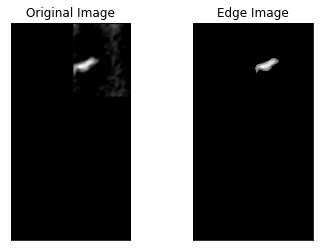

In [10]:
for c in range(masked_imgs.shape[0]):
    plt.subplot(121),plt.imshow(imgs[c],cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(masked_imgs[c],cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    
    if save_plt:
        plt.savefig(f"{dest_path}image{c}.png")

## Center of Gravity

## Axis of Least Inertia

## Scikit Learn Feature Extraction

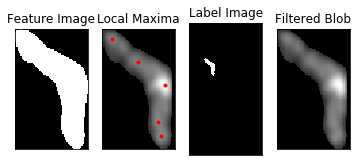

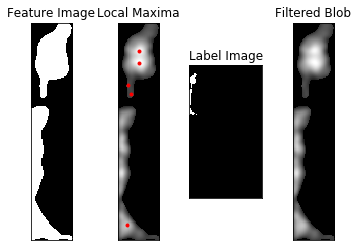

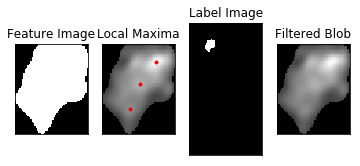

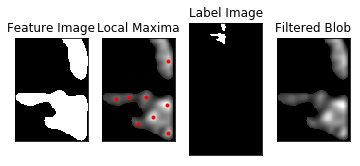

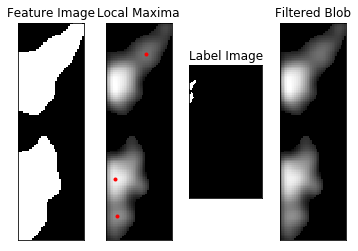

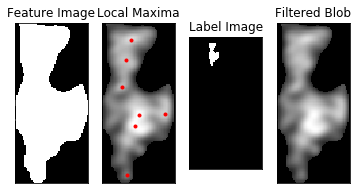

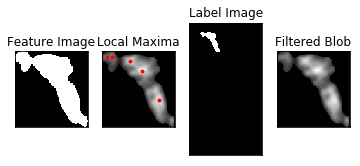

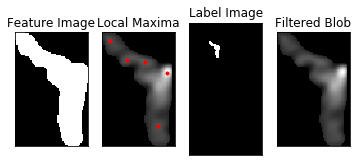

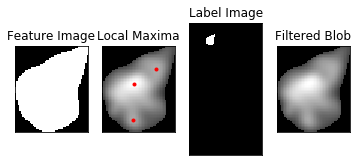

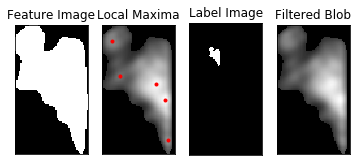

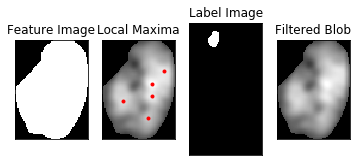

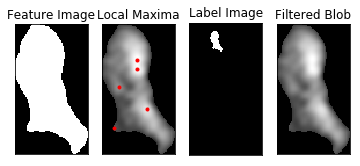

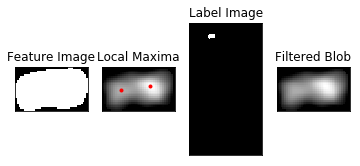

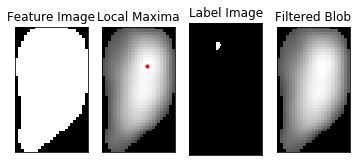

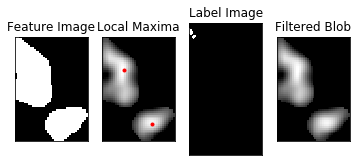

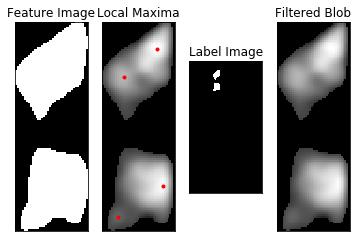

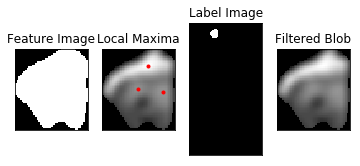

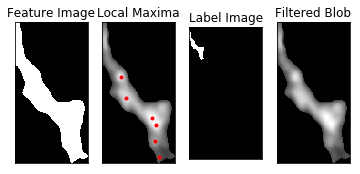

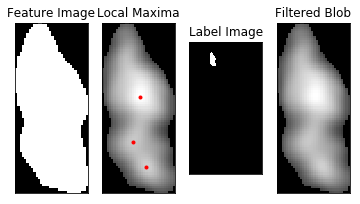

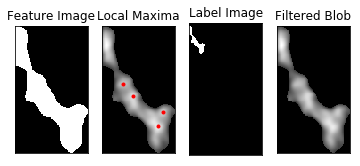

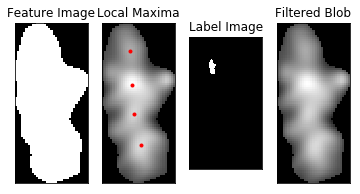

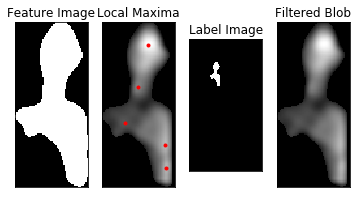

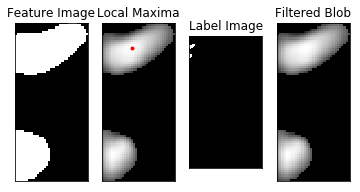

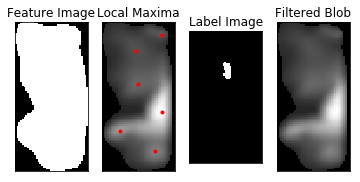

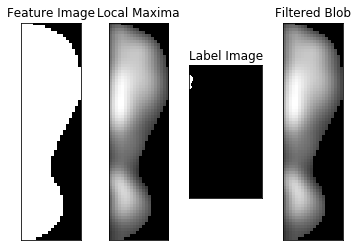

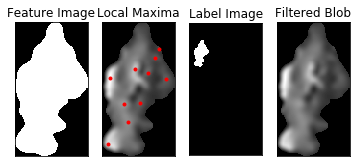

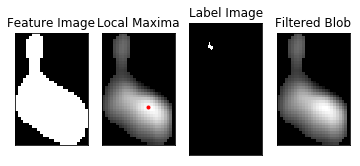

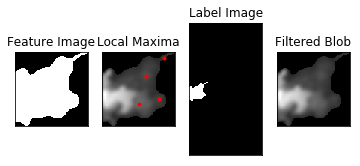

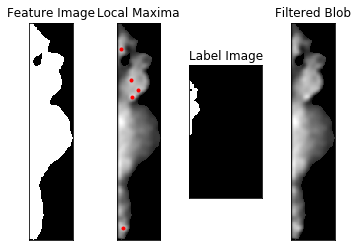

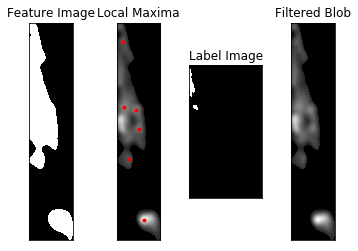

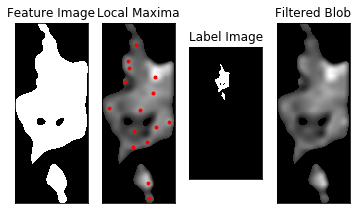

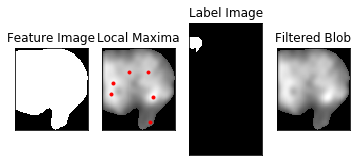

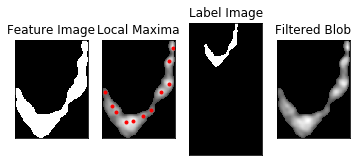

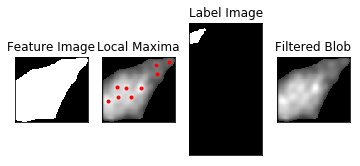

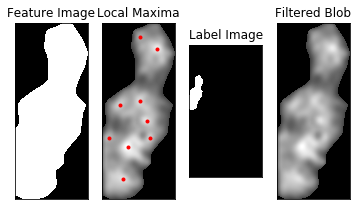

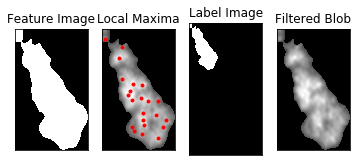

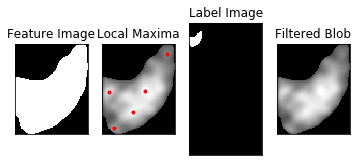

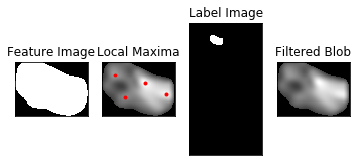

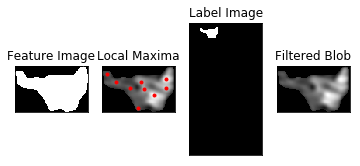

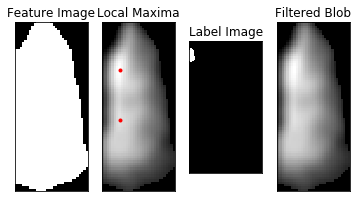

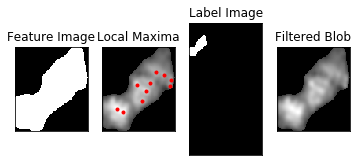

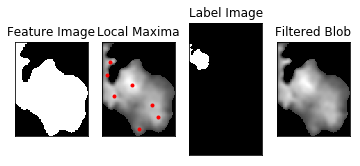

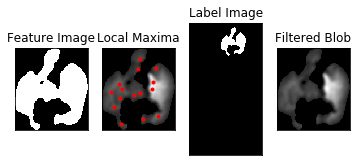

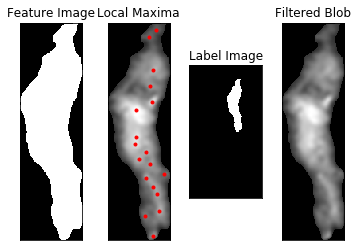

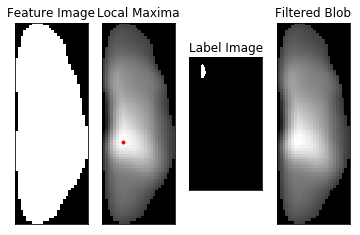

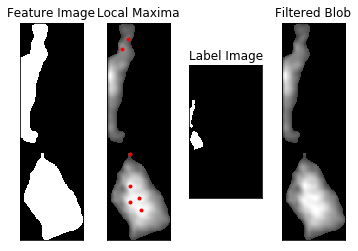

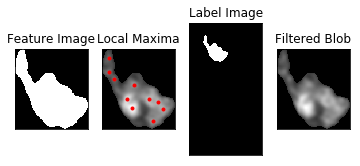

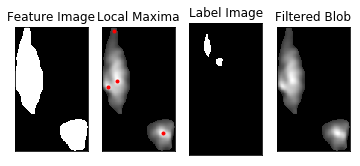

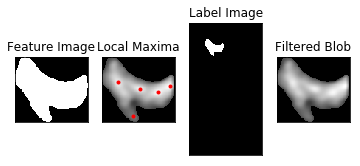

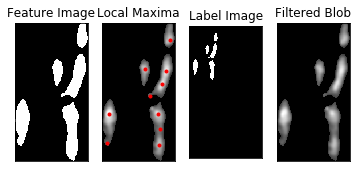

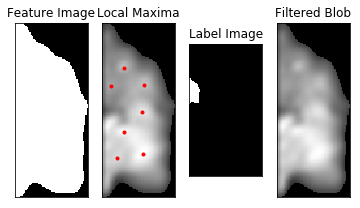

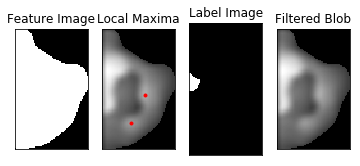

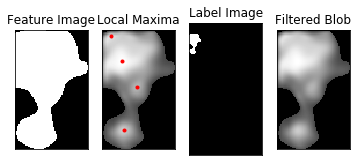

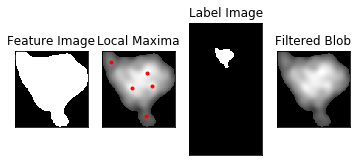

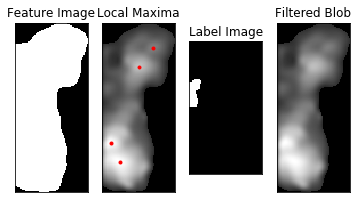

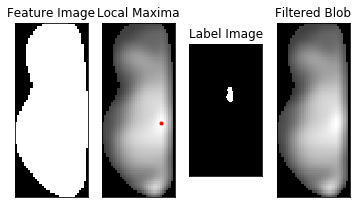

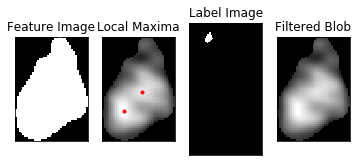

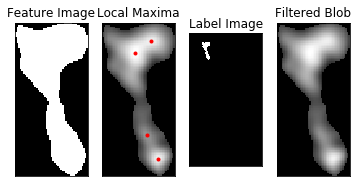

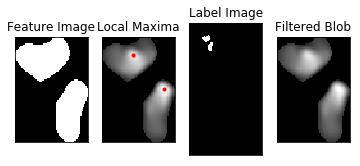

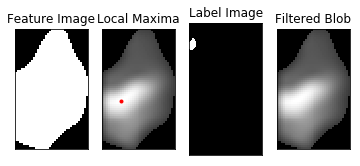

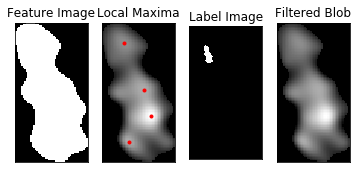

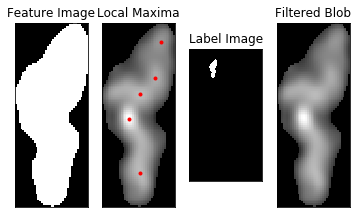

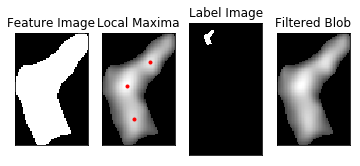

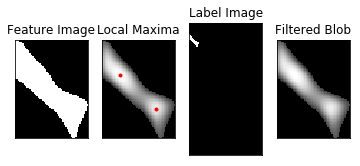

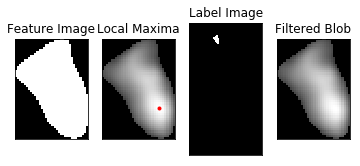

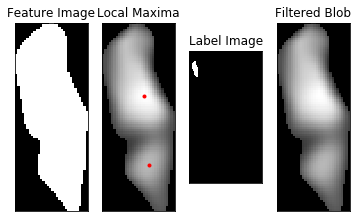

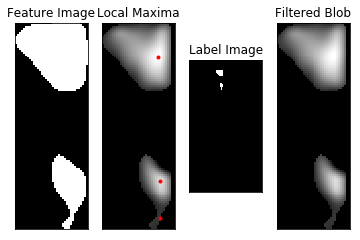

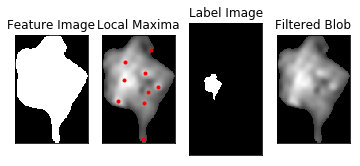

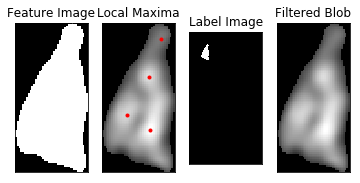

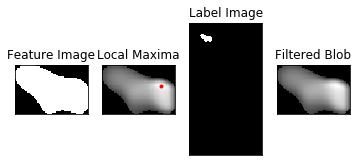

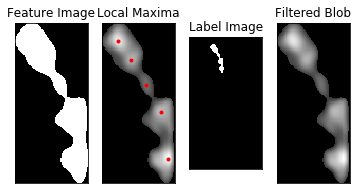

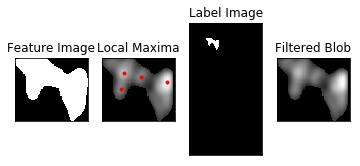

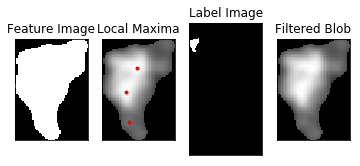

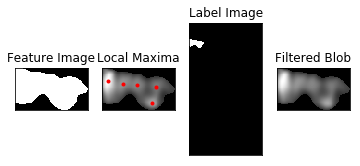

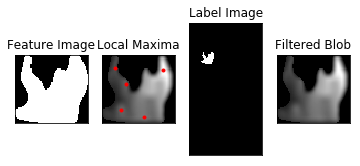

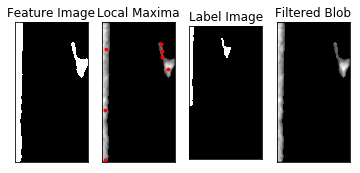

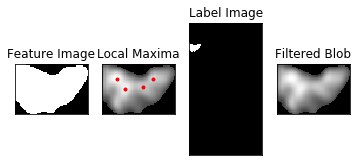

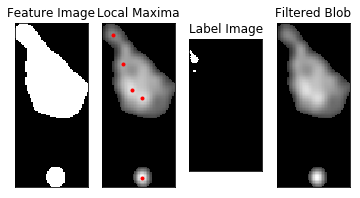

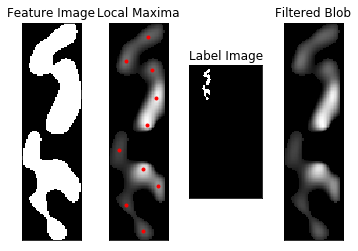

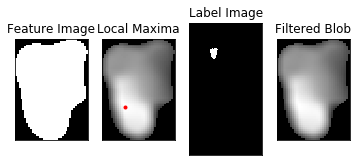

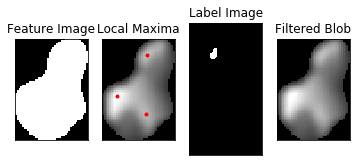

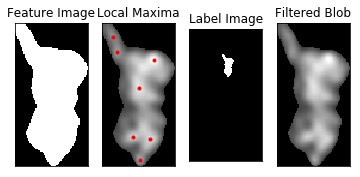

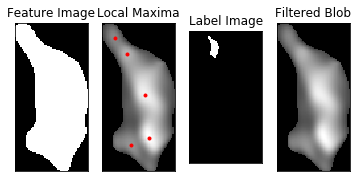

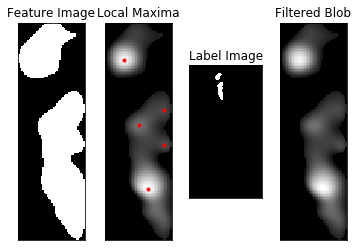

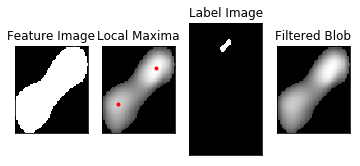

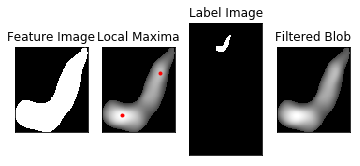

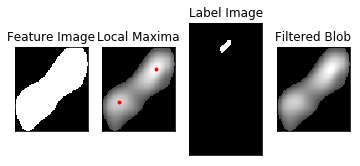

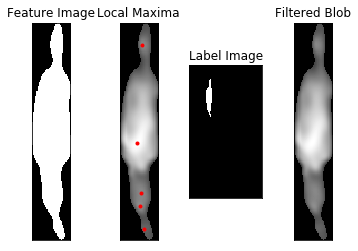

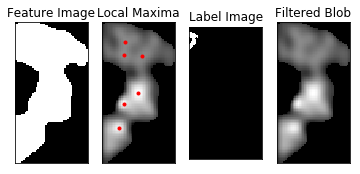

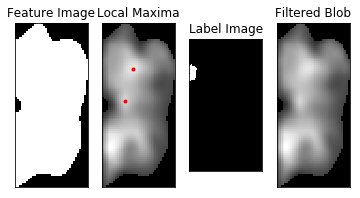

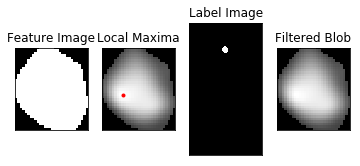

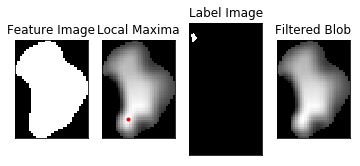

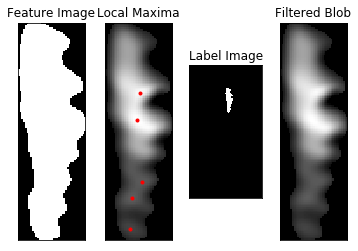

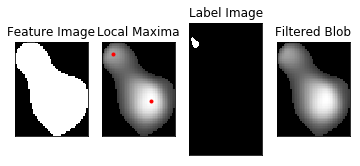

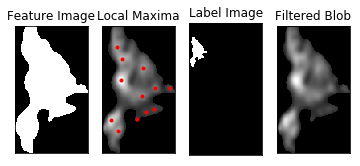

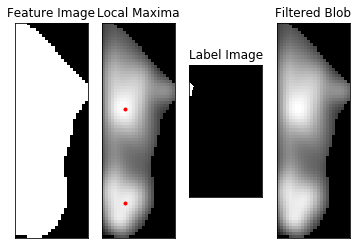

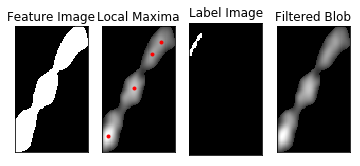

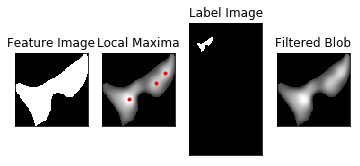

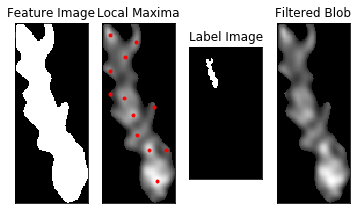

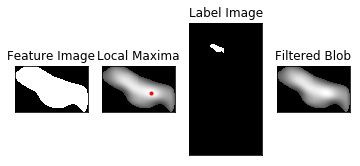

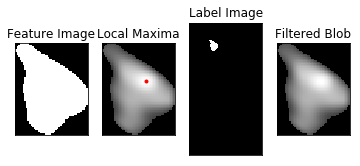

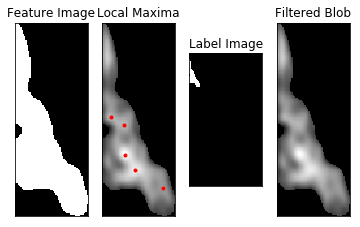

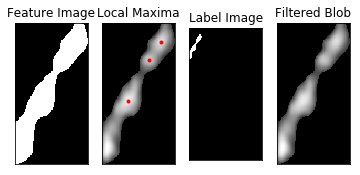

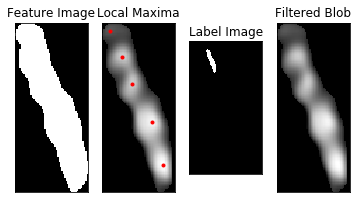

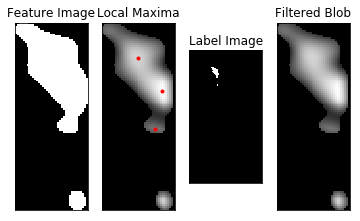

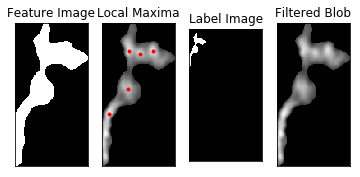

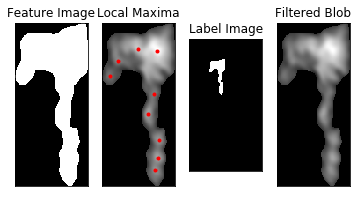

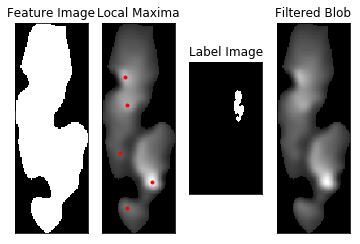

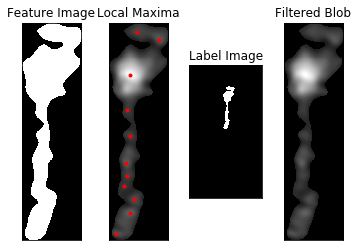

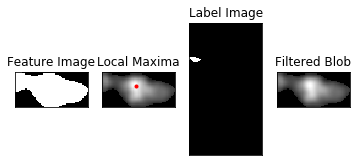

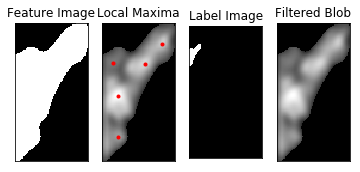

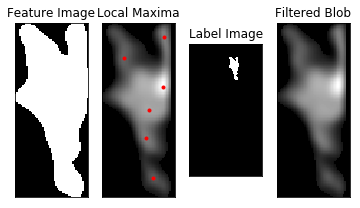

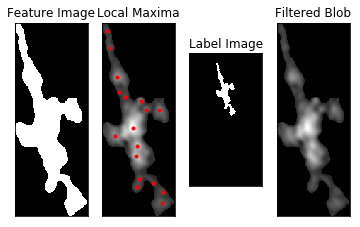

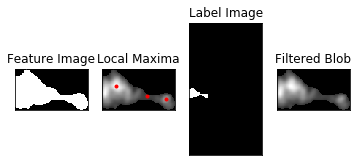

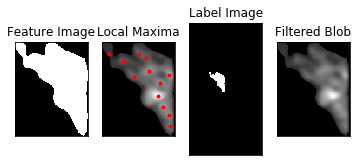

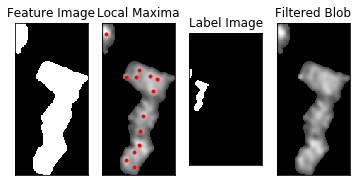

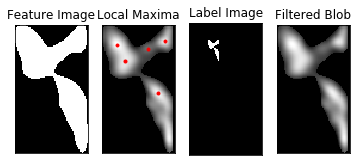

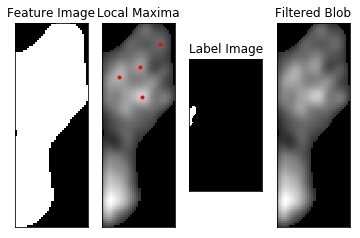

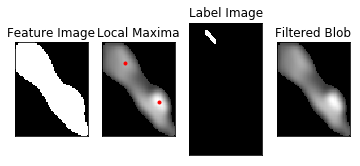

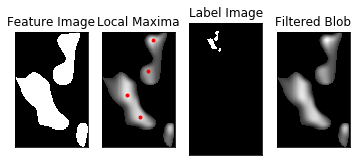

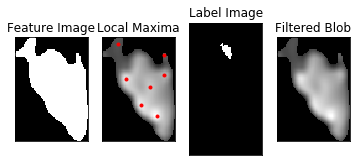

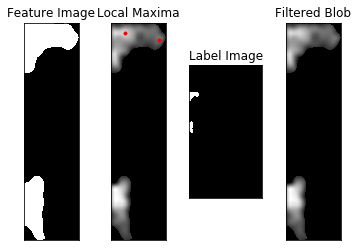

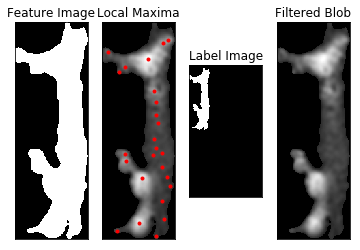

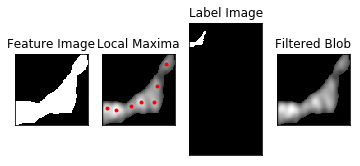

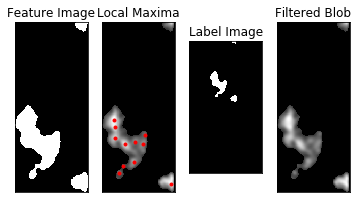

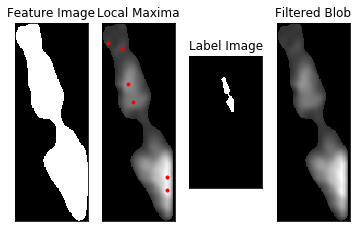

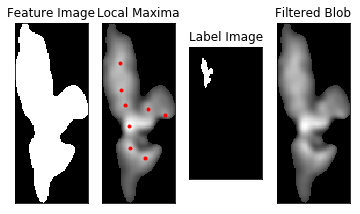

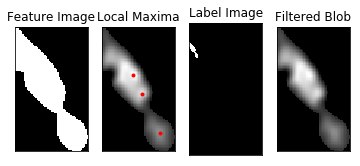

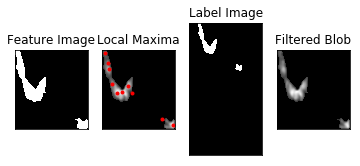

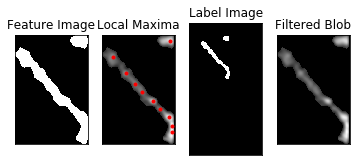

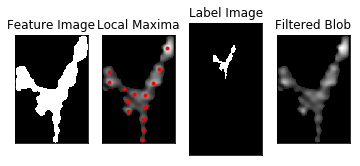

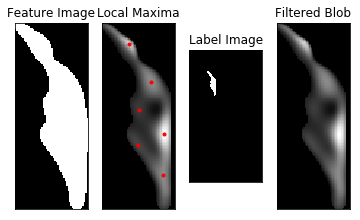

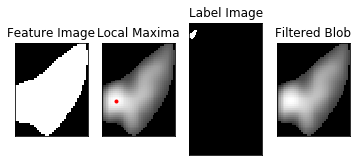

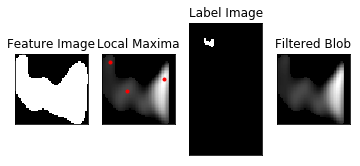

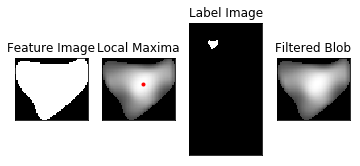

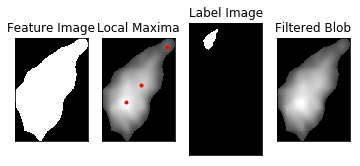

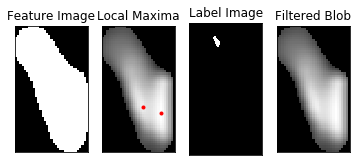

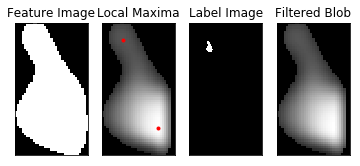

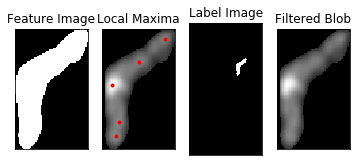

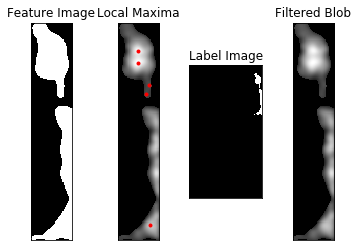

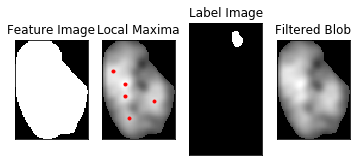

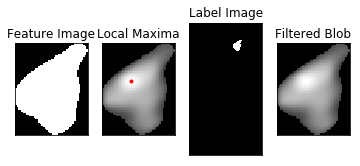

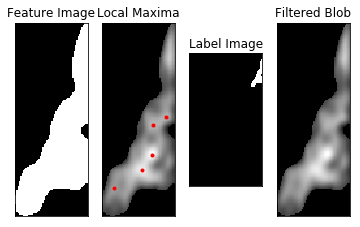

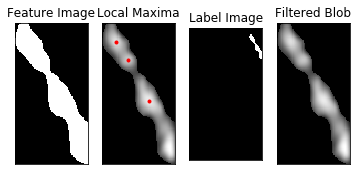

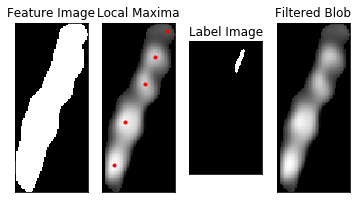

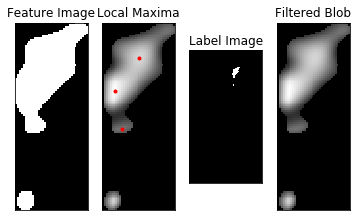

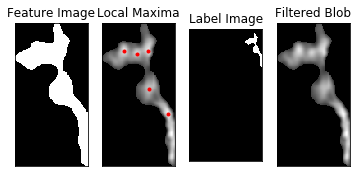

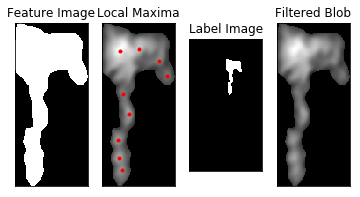

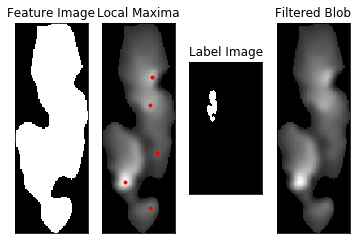

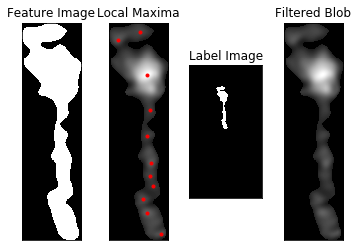

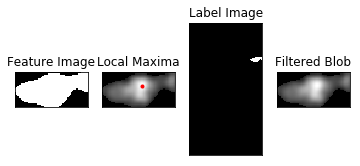

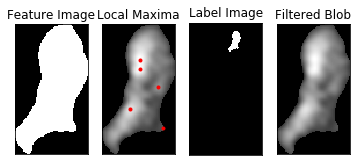

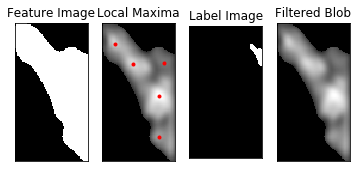

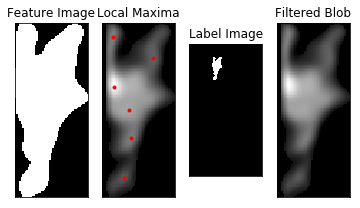

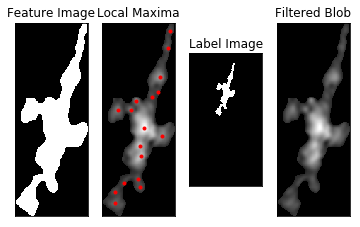

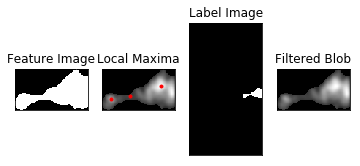

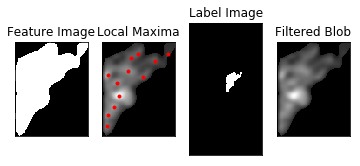

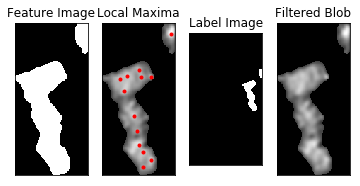

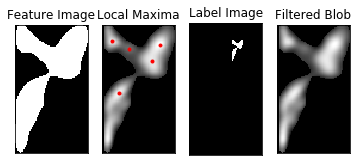

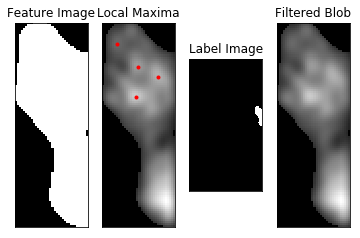

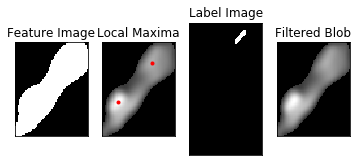

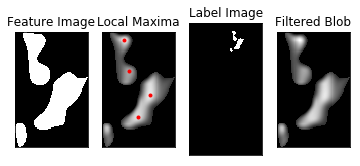

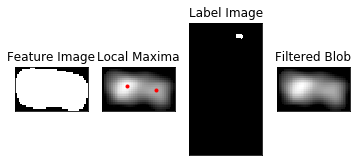

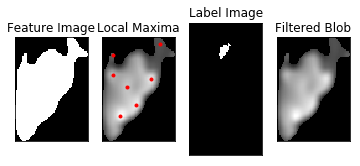

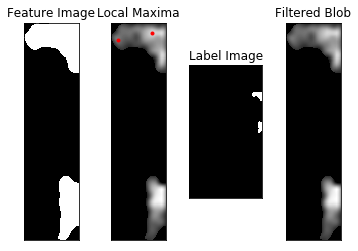

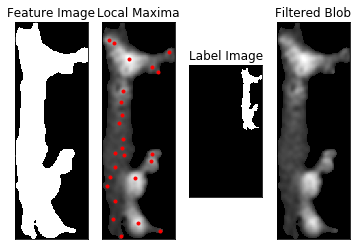

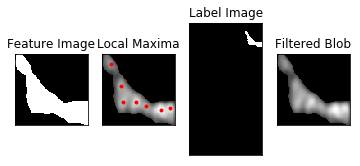

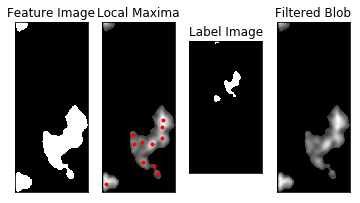

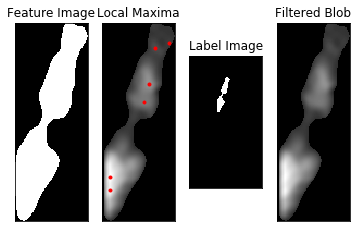

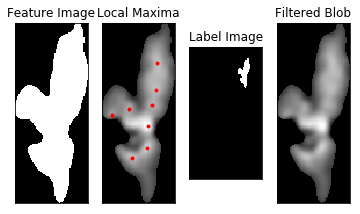

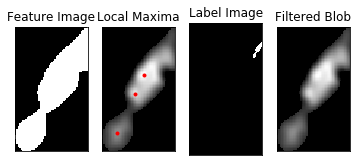

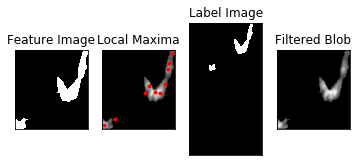

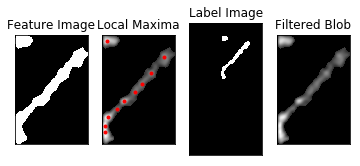

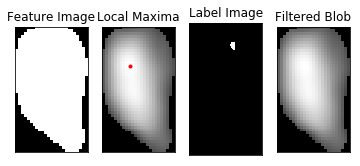

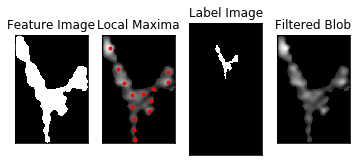

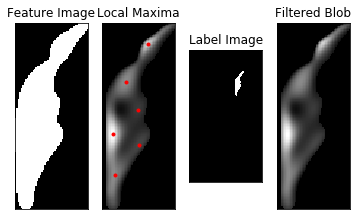

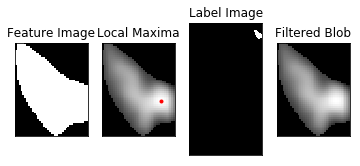

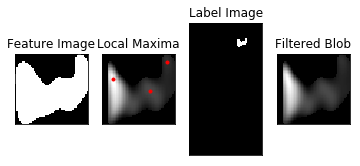

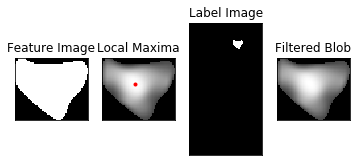

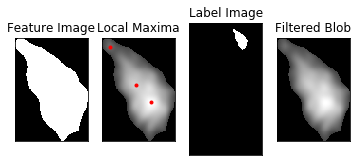

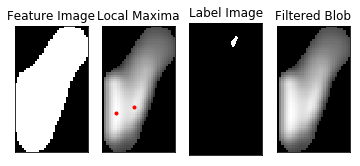

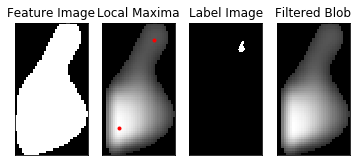

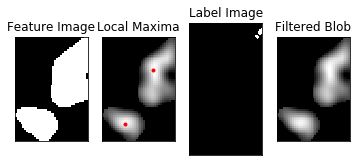

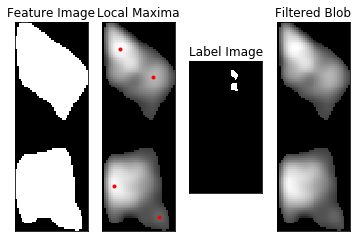

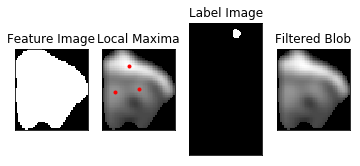

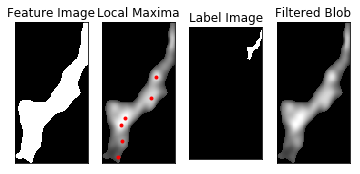

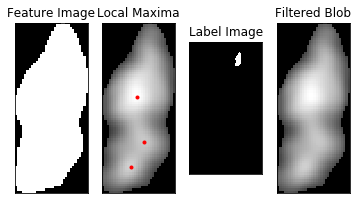

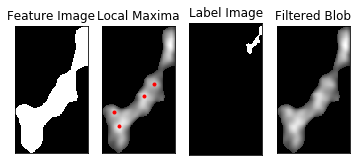

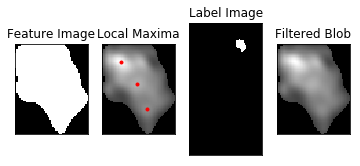

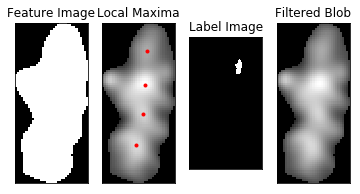

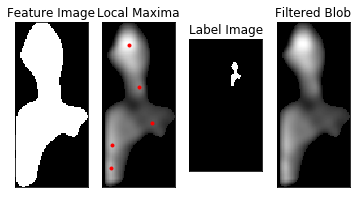

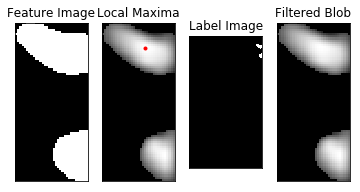

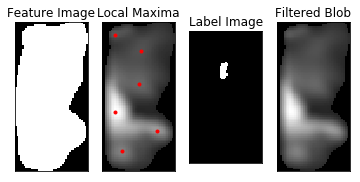

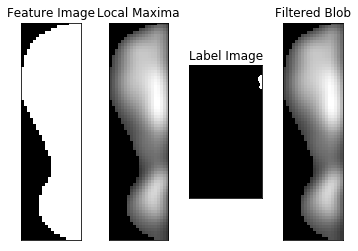

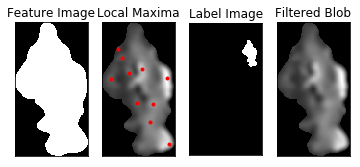

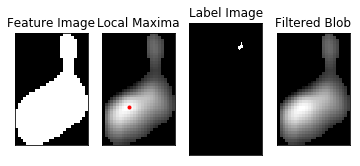

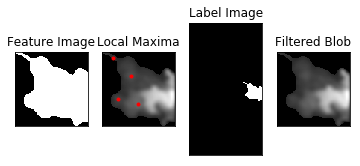

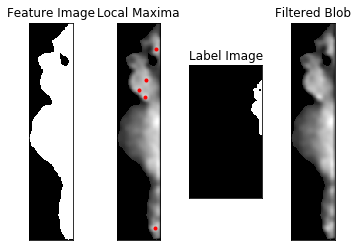

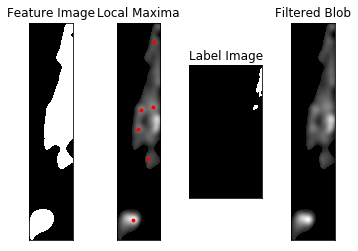

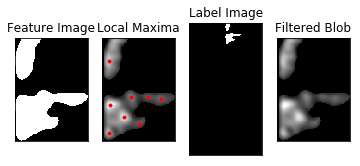

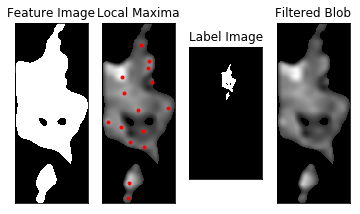

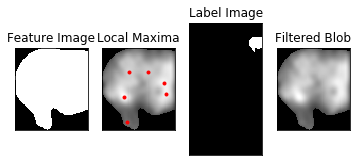

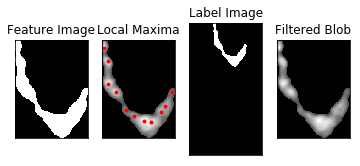

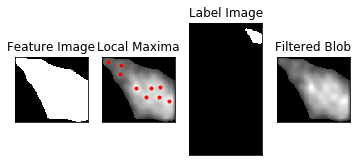

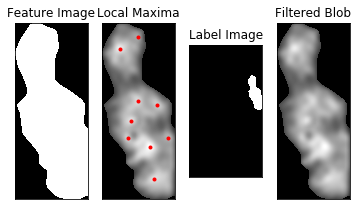

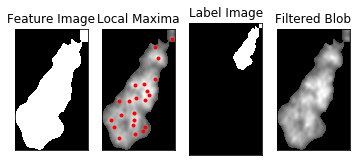

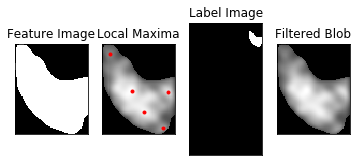

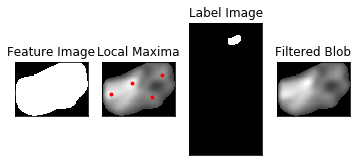

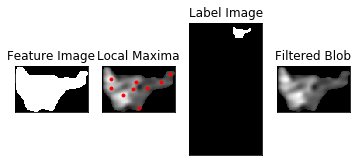

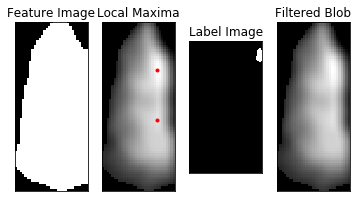

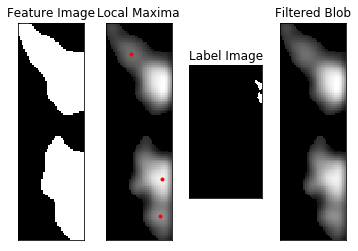

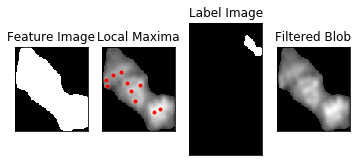

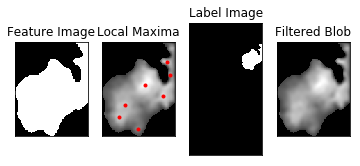

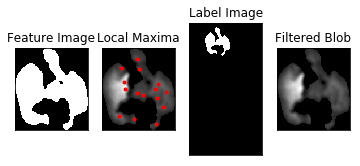

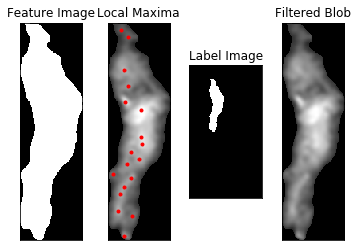

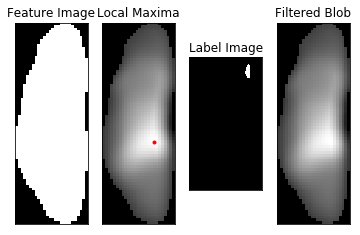

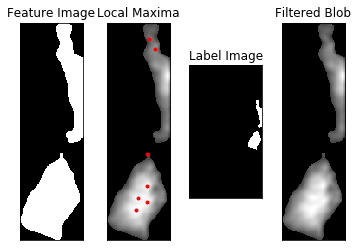

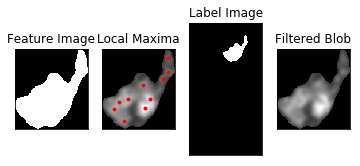

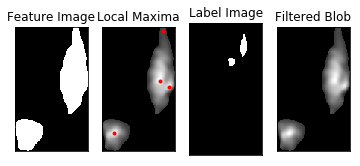

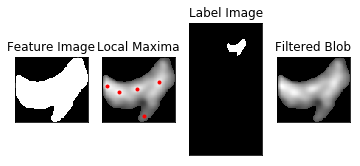

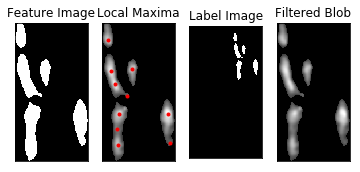

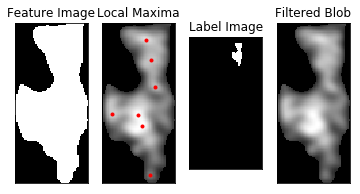

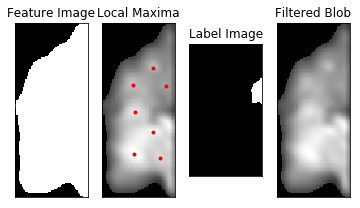

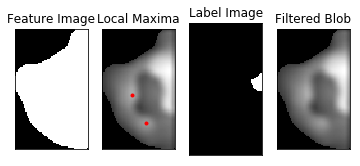

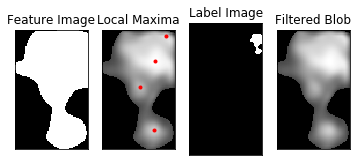

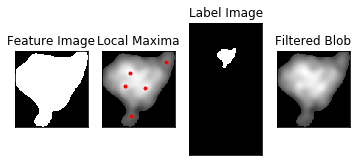

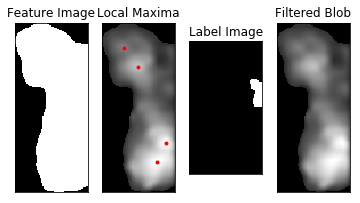

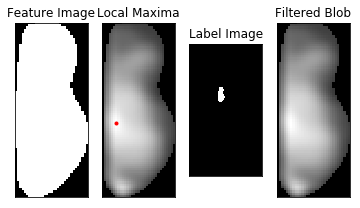

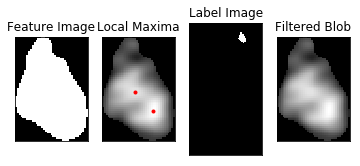

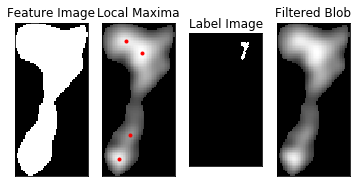

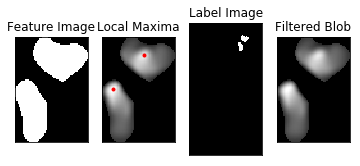

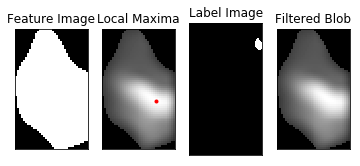

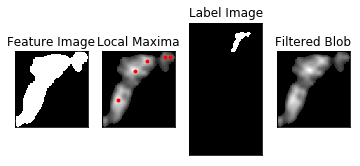

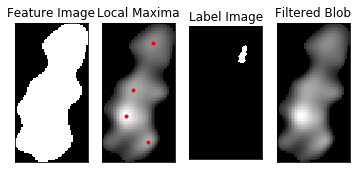

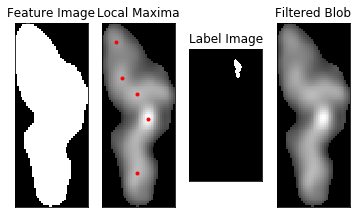

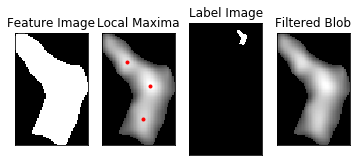

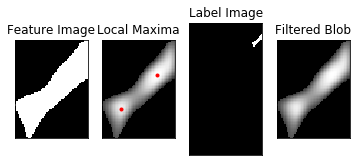

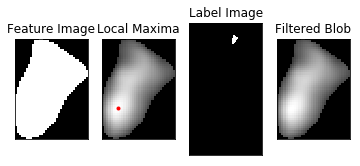

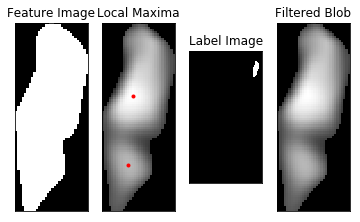

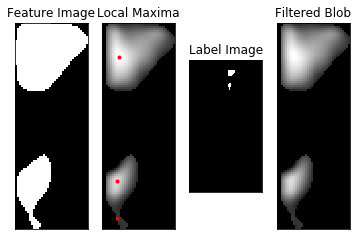

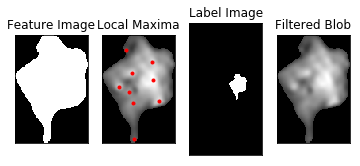

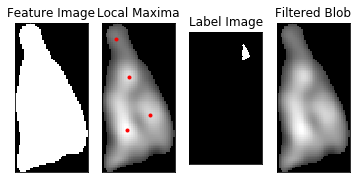

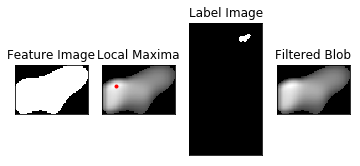

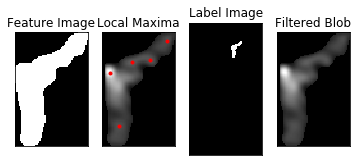

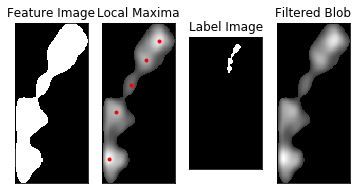

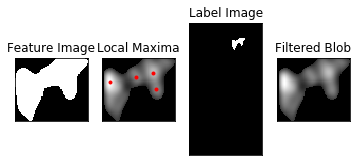

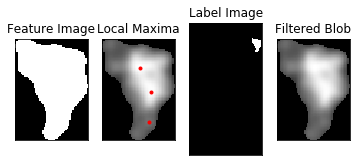

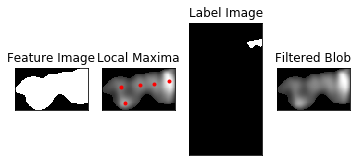

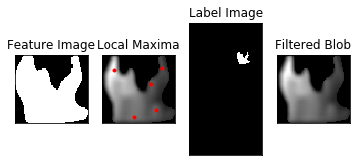

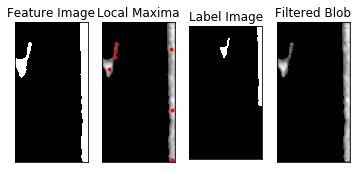

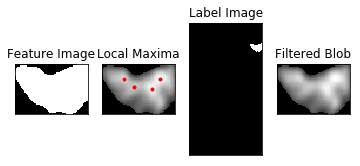

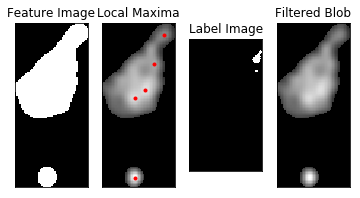

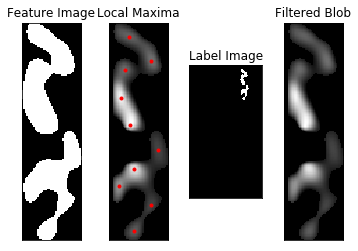

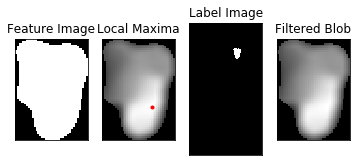

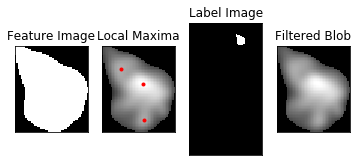

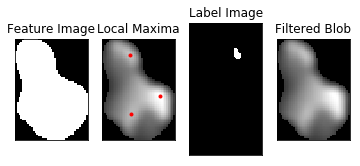

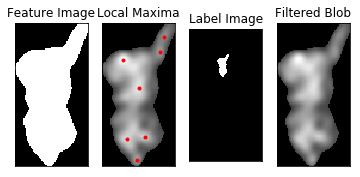

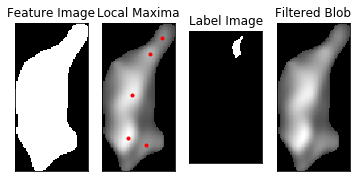

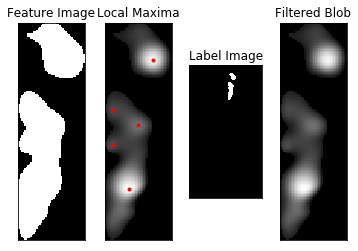

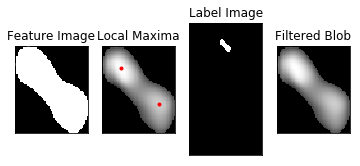

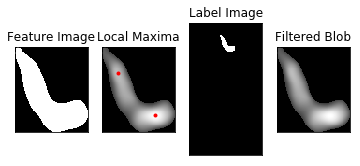

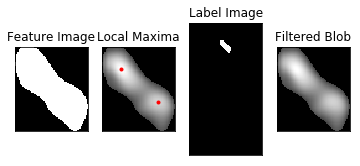

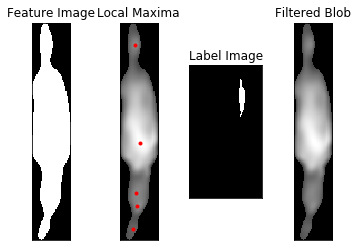

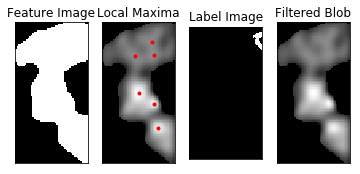

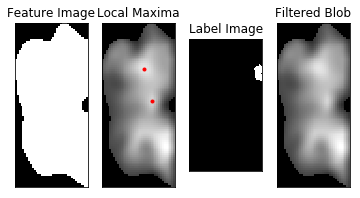

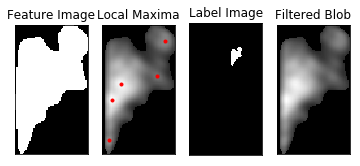

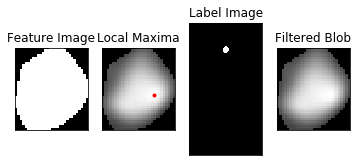

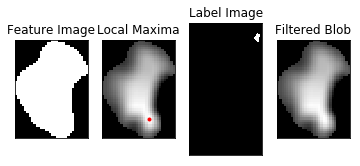

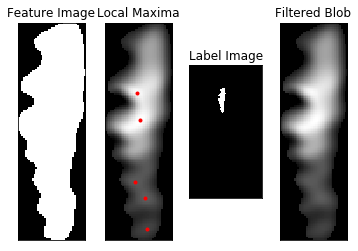

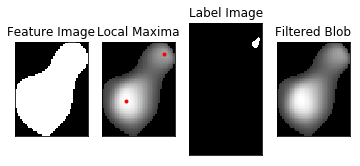

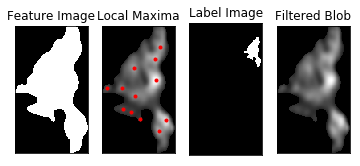

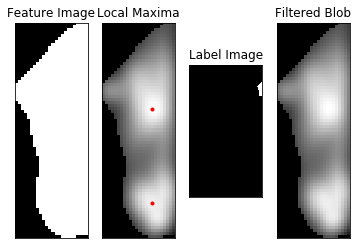

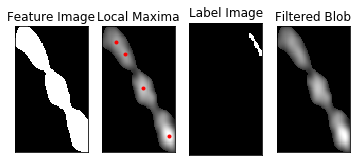

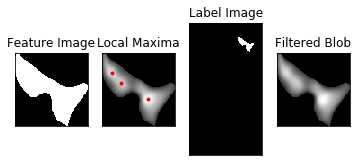

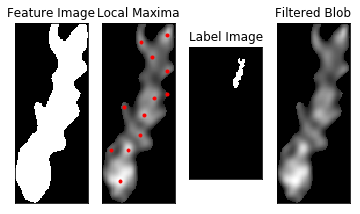

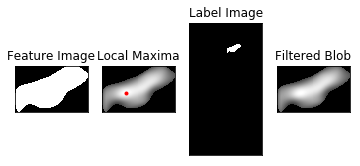

In [11]:
img_features = []

eccentricity = []
euler_number = []
extent = []
inertia_tensor = []

intensity_img = []
mask_img = []

mean_intensity = []

moments = []

orientation = []
perimeter = []

area = []
volume = []

sd = []
num_local_peaks = []

cropped_imgs = []
img_details = []

for i in range(len(masked_imgs)):
    features = measure.regionprops(img_masks[i].astype(int),masked_imgs[i])
    
    region = features[0]
    
    img_detail = {}
    
    eccentricity.append(region.eccentricity)
    euler_number.append(region.euler_number)
    extent.append(region.extent)
    inertia_tensor.append(region.inertia_tensor)
    
    intensity_img.append(region.intensity_image)
    mask_img.append(region.image)
    
    mean_intensity.append(region.mean_intensity)
    moments.append(region.moments)
    
    orientation.append(region.orientation)
    perimeter.append(region.perimeter)
    
    area.append(region.area)
    volume.append(masked_imgs[i].sum())
    
    sd.append(np.std(intensity_img[i]))
    
    # We find all local maxima
    '''local_maxima = extrema.local_maxima(intensity_img[i])
    label_maxima = label(local_maxima)
    overlay = color.label2rgb(label_maxima, intensity_img[i], alpha=0.7, bg_label=0,
                              bg_color=None, colors=[(1, 0, 0)])
    
    print(sum(label_maxima))'''
    
    coordinates = peak_local_max(intensity_img[i], min_distance=5)
    num_local_peaks.append(len(coordinates))
    
    #img_detail['local_maxima'] = list(coordinates)
    
    img_detail['local_maxima'] = []
    
    for a in list(coordinates):
        img_detail['local_maxima'].append(a.tolist())
    
    img_detail['moments'] = []
    
    for a in list(region.moments):
        img_detail['moments'].append(a.tolist())
    
    img_detail['inertia_tensor'] = []
    
    for a in list(region.inertia_tensor):
        img_detail['inertia_tensor'].append(a.tolist())
    
    plt.subplot(141),plt.imshow(region.image,cmap = 'gray')
    plt.title('Feature Image'), plt.xticks([]), plt.yticks([])
    #plt.subplot(142),plt.imshow(label_maxima,cmap = 'gray')
    plt.subplot(142),plt.imshow(intensity_img[i],cmap = 'gray')
    plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    plt.title('Local Maxima'), plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow(img_masks[i],cmap = 'gray')
    plt.title('Label Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(144),plt.imshow(intensity_img[i],cmap = 'gray') #masked_imgs[i]
    plt.title('Filtered Blob'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    img_features.append(features[0])
    img_details.append(img_detail)
    
df['eccentricity'] = eccentricity
df['euler_number'] = euler_number
df['extent'] = extent
df['inertia_tensor'] = inertia_tensor
df['mean_intensity'] = mean_intensity
df['moments'] = moments
df['orientation'] = orientation
df['perimeter'] = perimeter
df['volume'] = volume
df['area'] = area
df['sd'] = sd
df['num_local_peaks'] = num_local_peaks
# df['surface_area'] = surface_area

In [12]:
max_x = 0
max_y = 0

for img in intensity_img:
    max_x = max(max_x, img.shape[0])
    max_y = max(max_y, img.shape[1])

for i in range(len(intensity_img)):
    m = intensity_img[i]
    img = np.pad(np.copy(m), ((0,max_x-m.shape[0]),(0,max_y-m.shape[1])), 'constant', constant_values=(0))
    name = df['name'][i]
    
    if save_plt:
        np.save(f"{dest_path}\cropped\{name}.npy",img)

In [13]:
print(list(df))

['Unnamed: 0', 'name', 'date', 'flow_rate', 'source', 'peak_val', 'num_peaks', 'eccentricity', 'euler_number', 'extent', 'inertia_tensor', 'mean_intensity', 'moments', 'orientation', 'perimeter', 'volume', 'area', 'sd', 'num_local_peaks']


In [14]:
df.head()

,Unnamed: 0,name,date,flow_rate,source,peak_val,num_peaks,eccentricity,euler_number,extent,inertia_tensor,mean_intensity,moments,orientation,perimeter,volume,area,sd,num_local_peaks
0,0,0,2018.5.15,1800,13.10 s.tifheightmap.mat,4.292725,1,0.942129,1,0.390345,"[[200.864572583322, -238.0831653111234], [-238...",1.750114,"[[1876.0, 74413.0, 3912097.0, 238816981.0], [6...",-1.074760,238.551299,3283.213594,1876,0.965127,5
1,1,1,2018.5.15,1800,19.60 s.tifheightmap.mat,3.556529,2,0.991840,1,0.371580,"[[101.2435372609461, 341.4273094001988], [341....",1.682743,"[[3151.0, 301372.0, 43406692.0, 7296674266.0],...",1.495935,532.977705,5302.323770,3151,0.924200,5
2,2,2,2018.5.15,1800,20.40 s.tifheightmap.mat,5.438352,1,0.748055,1,0.655803,"[[167.81033289525976, 70.37316121279194], [70....",2.688651,"[[2294.0, 63819.0, 2333547.0, 97295601.0], [61...",1.031520,198.509668,6167.765745,2294,1.457413,3
3,3,3,2018.5.15,1800,23.60 s.tifheightmap.mat,3.368933,2,0.804690,1,0.344711,"[[335.7575758129534, 94.55285740392345], [94.5...",1.372364,"[[3050.0, 191844.0, 14789526.0, 1222721058.0],...",1.407120,390.007143,4185.710468,3050,0.756446,8
4,4,4,2018.5.15,1800,3.30 s.tifheightmap.mat,4.073374,2,0.978392,1,0.453700,"[[72.40151381492615, 144.47015738487244], [144...",1.786560,"[[2048.0, 118979.0, 9527117.0, 865768853.0], [...",1.453075,291.237590,3658.874888,2048,1.097356,3


In [17]:
df = df.drop(columns=['Unnamed: 0'])
df.to_csv(dest_path+id_file_name)

In [16]:
if save_plt:
    with open(dest_path+json_file_name, 'w') as outfile:
        json.dump(img_details, outfile)